# Análisis de la calidad de datos abiertos de personal del portal de datos abiertos del CPLT

### ¿Qué tan uniformes son los campos de las distintas fuentes de datos abiertos de la contratación de personal?

In [4]:
import pandas as pd
# importamos las columnas de cada archivo
col_planta = pd.read_csv('G:/temp/planta.csv', nrows=1, sep=',').keys().tolist()
col_contrata = pd.read_csv('G:/temp/contrata.csv', nrows=1, sep=',').keys().tolist()
col_honorarios = pd.read_csv('G:/temp/honorarios.csv', nrows=1, sep=',').keys().tolist()
col_codigo = pd.read_csv('G:/temp/codTrabajo.csv', nrows=1, sep=',').keys().tolist()

# unimos las columnas en una lista
cols = [col_planta, col_contrata, col_honorarios, col_codigo]

# loop para revisar cuales son todos los campos
col_t = []
for l in cols:
    for col in l:
        if col not in col_t:
            col_t.append(col)
            
# se almacena en un dataframe
dfcols = pd.DataFrame(col_t, columns =['Campos'])

# se crean los otros dataframes para luego hacer un merge
dfs = ['dfplanta', 'dfcontrata', 'dfhonorarios', 'dfcodigo']
datasets = ['Planta', 'Contrata', 'Honorarios', 'Codigo del trabajo']

a = zip(dfs, cols)

lista_dfs = {}
for df, file in a:
    lista_dfs[df] = pd.DataFrame(file, columns=['Campos'])
    lista_dfs[df]['Existe'] = 'Si'
    
for i, dfs in enumerate(lista_dfs):
    dfcols = dfcols.merge(lista_dfs[dfs], how='left').rename(columns={'Existe':datasets[i]})
dfcols = dfcols.fillna('No')

dfcols

FileNotFoundError: [Errno 2] No such file or directory: 'G:/temp/planta.csv'

### ¿Cuál es el campo que indica la fecha o periódo de publicación?

In [14]:
#Importamos las credenciales que usaremos en todo el notebook para conectarnos al ambiente de vertica
import os
import vertica_python

user = os.getenv('vertuser')
passwd = os.getenv('vertpass')
host = os.getenv('verthost')
db = os.getenv('vertdb')
port = os.getenv('vertport')

# información de conexión a vertica
conn_info = {'host': host,
             'port': port,
             'user': user,
             'password': passwd,
             'database': db,
             'unicode_error': 'strict',
             'ssl': False,
             'use_prepared_statements': False}

In [15]:
# conexión simple con cierre manual
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query1 = '''
SELECT round(SUM(año)/count(año), 4) * 100 as '% en que no coincide año', 
round(SUM(Mes)/count(Mes), 4) * 100 as '% en que no coincide mes',
round(SUM(Ambos)/count(Ambos), 4) * 100 as '% en que no coinciden ambos'
FROM (
SELECT 
CASE WHEN f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as año,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) then 0 else 1 end as Mes,
CASE WHEN to_number(MesN) = month(date(fechapublicacion)) and f.anyo = YEAR(date(fechapublicacion)) then 0 else 1 end as Ambos
FROM funcionarios."full" f 
) as t
'''

df1 = pd.read_sql(query1, cnxn)

cnxn.close()
df1

,% en que no coincide año,% en que no coincide mes,% en que no coinciden ambos
0,85.81,92.31,99.86


### ¿Desde cuando se publica?

In [16]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query2 = '''
SELECT f.anyo as Año , f.Mes  as Mes , count(*) as 'Cantidad de registros'
FROM funcionarios."full" f 
GROUP BY f.anyo , f.Mes, mesN
order by f.anyo, mesN asc
'''

df2 = pd.read_sql(query2, con=cnxn)
# añadimos año-mes
df2['mesAño'] = df2['Año'].astype(str) + '-' + df2['Mes']

cnxn.close()

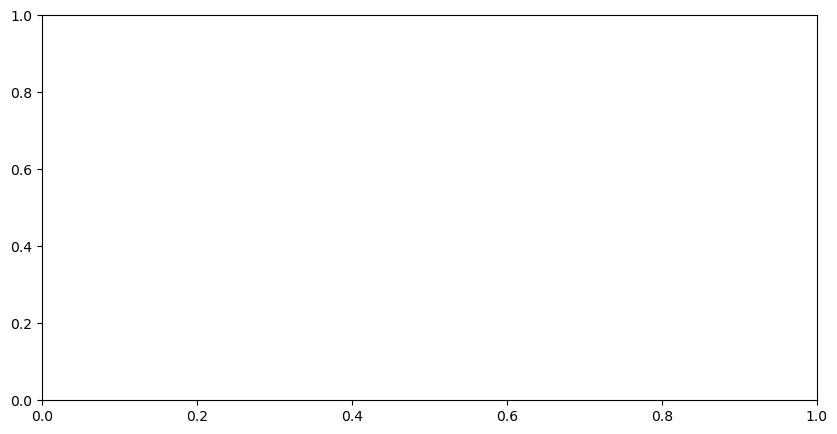

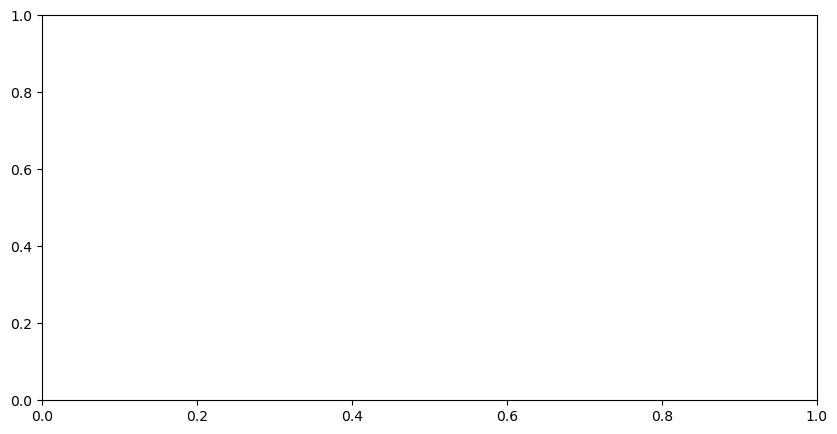

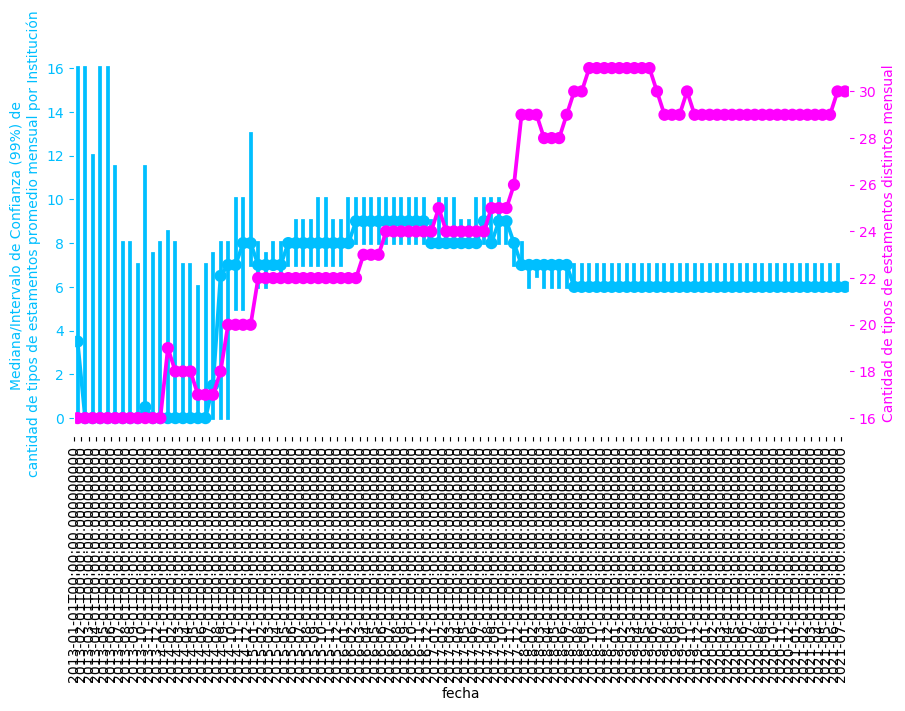

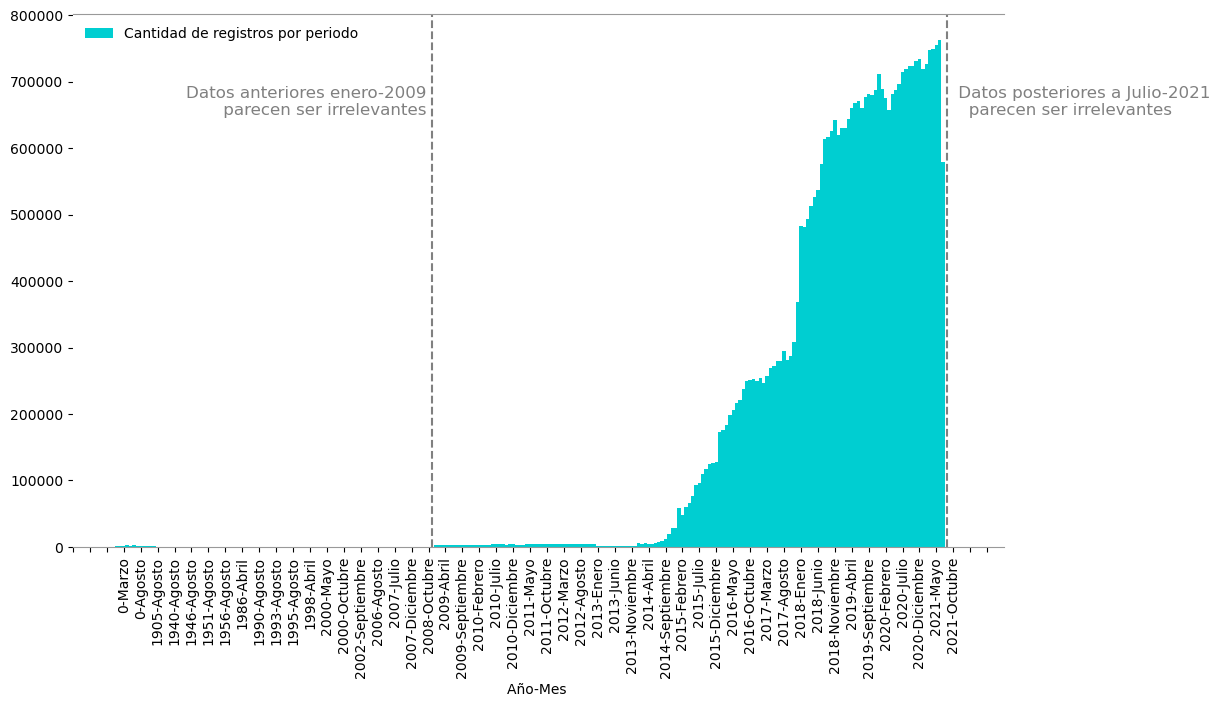

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fast')

y = df2['Cantidad de registros']
x = df2['mesAño']

fig, ax = plt.subplots(figsize=(10,6))
plt.xticks(rotation=90)
plt.tight_layout() 
plt.bar(x, y, width=1, color='darkturquoise')
stepsize = 5
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax.set_xlabel('Año-Mes ')

# color de los ejes 
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(['Cantidad de registros por periodo'], loc = 'upper left', shadow = False, edgecolor = 'white')

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2008-Diciembre'].index.values[0]], 650000,\
         'Datos anteriores enero-2009 \n parecen ser irrelevantes ', color = 'grey',\
        horizontalalignment='right', fontsize=12)

plt.text(df2['mesAño'][df2[df2['mesAño'] == '2021-Octubre'].index.values[0]], 650000,\
         ' Datos posteriores a Julio-2021\n   parecen ser irrelevantes', color = 'grey',\
        horizontalalignment='left', fontsize=12)

ax.axvline(x='2008-Diciembre', color = 'grey', ls = '--')
ax.axvline(x='2021-Agosto', color = 'grey', ls = '--')
plt.savefig('fig1.png')
plt.show()

### ¿Quienes publican periodos inconsistentes?

In [18]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query3 = '''
SELECT f.OrganismoCodigo, f.OrganismoNombre, count(distinct concat(f.anyo, f.Mes)) cant_periodos 
FROM funcionarios."full" f 
WHERE (f.anyo < 2009 or f.anyo > 2021)
or (f.anyo = 2021 and f.mesN in ('09', '10', '11', '12'))
GROUP  By f.OrganismoCodigo, f.OrganismoNombre
'''

df3 = pd.read_sql(query3, con=cnxn)

cnxn.close()
print(len(df3))
rank10 = df3.sort_values(by='cant_periodos', ascending=False).head(10).sort_values(by='cant_periodos')

300


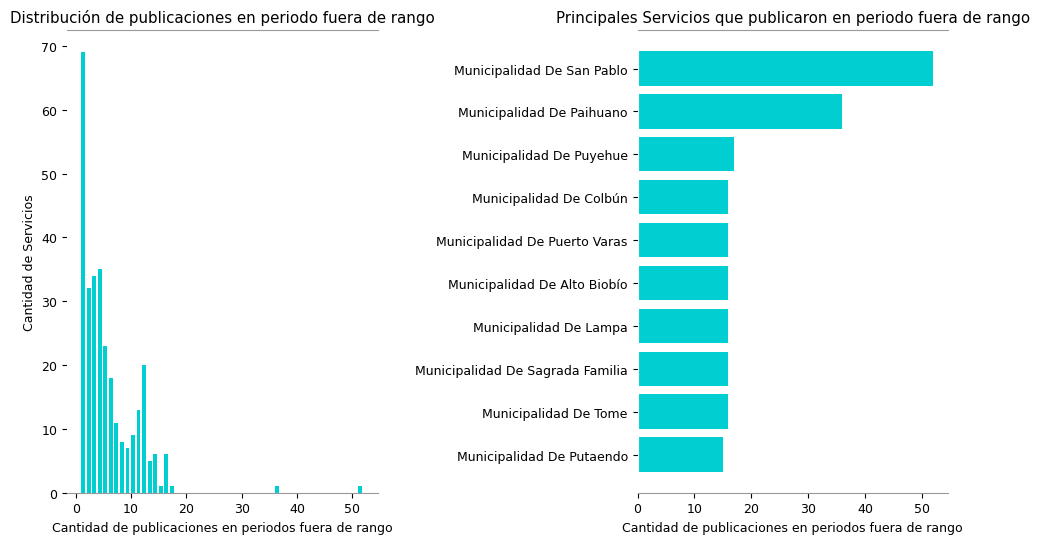

In [19]:
plt.rcParams.update({'font.size': 9})
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(10,6))
y1 = rank10['OrganismoNombre']
x1 = rank10['cant_periodos']

x2 = df3['cant_periodos']

# color de los ejes 
ax0.spines['bottom'].set_color('#999')
ax0.spines['top'].set_color('#999') 
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

# color de los ejes 
ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')

ax0.hist(x2, bins = 51, color = 'darkturquoise', width=0.7)
ax0.set_title('Distribución de publicaciones en periodo fuera de rango')
ax0.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax0.set_ylabel('Cantidad de Servicios')

ax1.barh(y1, x1, color= 'darkturquoise')
ax1.set_xlabel('Cantidad de publicaciones en periodos fuera de rango')
ax1.set_title('Principales Servicios que publicaron en periodo fuera de rango')

plt.rcParams["font.family"] = "sans-serif"
fig.tight_layout(pad=3)
plt.show()

### ¿Cuándo se hicieron estos registros equivocados?

In [20]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query4 = '''
SELECT date(FechaPublicacion) fecha , count(distinct OrganismoCodigo ) cantidadservicios, count(f.FechaPublicacion) cantidadregistros
FROM funcionarios."full" f 
WHERE (f.anyo < 2009 or f.anyo > 2021)
or (f.anyo = 2021 and f.mesN in ('09', '10', '11', '12'))
GROUP  By date(FechaPublicacion)
'''
df4 = pd.read_sql(query4, con=cnxn)
df4.fecha = pd.to_datetime(df4['fecha'])
df4 = df4.sort_values(by=['fecha'])
cnxn.close()

In [21]:
df4.sort_values(by=['cantidadregistros'], ascending=False).head(5)

,fecha,cantidadservicios,cantidadregistros
41,2021-08-13,64,3154
30,2021-12-08,36,2601
27,2021-07-29,4,2446
29,2021-11-08,17,1538
28,2021-08-16,23,1354


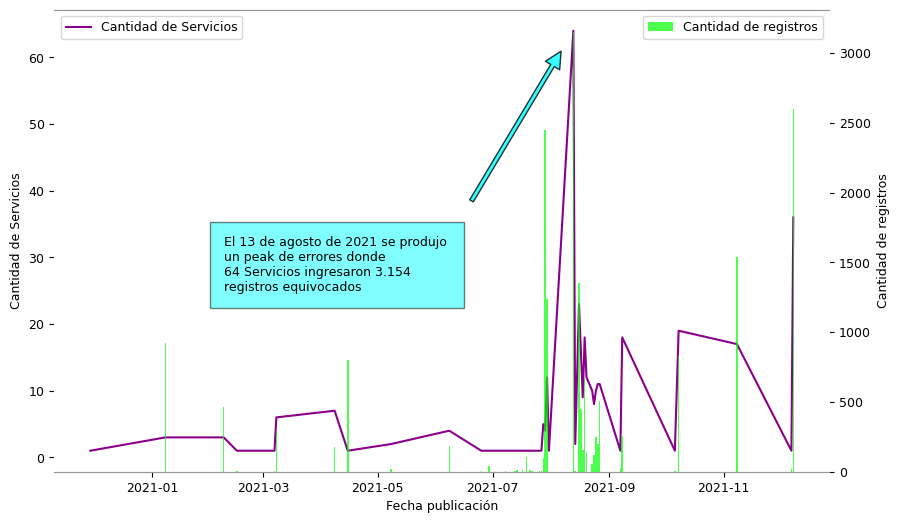

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax1 = ax.twinx()
ax.plot(df4['fecha'], df4['cantidadservicios'], c='darkmagenta')
ax1.bar(df4['fecha'], df4['cantidadregistros'], alpha=0.7, color='lime')

ax.set(ylabel='Cantidad de Servicios')
ax1.set(ylabel='Cantidad de registros')
ax.legend(['Cantidad de Servicios'], loc='upper left')
ax1.legend(['Cantidad de registros'], loc='upper right')

# color de los ejes 
ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

ax1.spines['bottom'].set_color('#999')
ax1.spines['top'].set_color('#999') 
ax1.spines['right'].set_color('white')
ax1.spines['left'].set_color('white')
ax1.set_xlabel('Fecha publicación')
ax.set_xlabel('Fecha publicación')
ax.annotate('El 13 de agosto de 2021 se produjo \nun peak de errores donde \n64 Servicios ingresaron 3.154 \nregistros equivocados', xy=(df4[df4['fecha']== '2021-08-13']['fecha'],64)
          , xytext=(df4[df4['fecha']== '2021-02-08']['fecha'],25), arrowprops=dict(facecolor='cyan', alpha=0.8,shrink=0.1, width=3), bbox={'facecolor': 'cyan', 'alpha': 0.5, 'pad': 10})


plt.show()

### ¿Cuáles son las instituciones que publican en el dataset?

In [23]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# hacemos la query  e importamos el resultado en un df
query5 = '''SELECT * FROM funcionarios.Servicios'''
df5 = pd.read_sql(query5, con=cnxn)
cnxn.close()
df5

,Codigo_org,idOrg,Organismo,Codigo_padre,Padre_org,Region,Municipalidad,direccion,telefono,url_organismo,...,banco,url_sai,fax,Ingresa,obligadorecibir_sai,organismo_autonomo,interopera,tiene_ta,fecha_ta,activado
0,AA001,757,Presidencia de la República,AA000,Presidencia de la República,Región Metropolitana de Santiago,SANTIAGO,Morandé #130,56 2 2690 4798,http://www.gobiernodechile.cl/,...,None,http://transparenciaactiva.presidencia.cl/,None,Ingresa,SÍ,NO,NO,SÍ,2018/11/16,SÍ
1,AB001,758,Subsecretaría del Interior,AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Teatinos N 92 piso 7 Edificio Moneda Bicentenario,224863520,http://www.interior.gob.cl/,...,None,https://siac.interior.gob.cl/formulario.gov?ac...,None,Ingresa,SÍ,NO,NO,SÍ,None,SÍ
2,AB002,961,Subsecretaría de Desarrollo Regional y Adminis...,AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Teatinos N92 Piso 2 y 3.,26363600,http://www.subdere.cl/,...,None,http://www.subdere.gov.cl/transparencia/ley202...,None,Ingresa,SÍ,NO,NO,SÍ,2018/06/14,SÍ
3,AB003,962,Agencia Nacional de Inteligencia (ANI),AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Tenderini 115,56 2 2630 5000,http://,...,None,https://siac.interior.gob.cl/formulario.gov?ac...,None,Ingresa,SÍ,NO,NO,SÍ,None,SÍ
4,AB004,963,Oficina Nacional de Emergencia (ONEMI),AB000,Interior y Seguridad Pública,Región Metropolitana de Santiago,SANTIAGO,Beaucheff 1671,222524369 222524370,http://www.onemi.cl/,...,None,https://siac.onemi.gov.cl,None,Ingresa,SÍ,NO,NO,SÍ,2018/01/01,SÍ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,UN014,1084,Universidad de La Frontera (UFRO),UN000,Universidades,Región de La Araucanía,TEMUCO,AV. FRANCISCO SALAZAR,(45) 325000,http://www.ufro.cl/,...,None,http://www2.ufro.cl/transparencia/,None,No ingresa,SÍ,NO,NO,NO,None,SÍ
989,UN015,1077,Universidad de Los Lagos,UN000,Universidades,Región de Los Lagos,OSORNO,AV. FUCHSLOCHER 1305 OSORNO,(64) 333 000,http://www.ulagos.cl/,...,None,http://transparencia.ulagos.cl/?page_id=81,None,No ingresa,SÍ,NO,NO,NO,None,SÍ
990,UN016,1078,Universidad de Magallanes,UN000,Universidades,Región de Magallanes y de la Antártica Chilena,PUNTA ARENAS,Oficina de Partes AV. BULNES 01855 PUNTA ARENAS,(61) 2207000,http://www.umag.cl/,...,None,http://analisis.umag.cl/transparencia/solicitu...,None,Ingresa,SÍ,NO,NO,NO,None,SÍ
991,UN017,58901,Universidad de Aysén,UN000,Universidades,Región de Aysén del General Carlos Ibáñez del ...,COIHAIQUE,Obispo Vielmo N62 Coyhaique,+56 67 2332201,http://www.uaysen.cl/,...,None,http://www.uaysen.cl/,None,Ingresa,SÍ,NO,NO,SÍ,2018/01/01,SÍ


In [24]:
display(pd.crosstab(df5["obligadorecibir_sai"],df5["Ingresa"], 
values=df5["Codigo_org"],aggfunc='count'))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["Ingresa"], 
values=df5["Codigo_org"],aggfunc='count', normalize=True))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["interopera"], 
values=df5["Codigo_org"],aggfunc='count'))

display(pd.crosstab(df5["obligadorecibir_sai"],df5["interopera"], 
values=df5["Codigo_org"],aggfunc='count', normalize=True))

Ingresa,Ingresa,No ingresa
obligadorecibir_sai,,
NO,3,90
SÍ,769,131


Ingresa,Ingresa,No ingresa
obligadorecibir_sai,,
NO,0.003021,0.090634
SÍ,0.774421,0.131923


interopera,NO,SÍ
obligadorecibir_sai,,
NO,93.0,NaN
SÍ,865.0,35.0


interopera,NO,SÍ
obligadorecibir_sai,,
NO,0.093656,0.000000
SÍ,0.871098,0.035247


### De los servicios obligados ¿Cuáles agrupaciones Ingresan?

In [25]:
dfobligados = df5[df5['obligadorecibir_sai'] == 'SÍ']

In [26]:
dftemp =pd.crosstab(dfobligados["Padre_org"],dfobligados["Ingresa"], 
values=dfobligados["Codigo_org"],aggfunc='count').fillna(0)
dftemp["Total"] = dftemp['Ingresa'] + dftemp['No ingresa']
dftemp= dftemp.reset_index().sort_values(by=['Total'])
dftemp.to_excel('temp.xlsx')

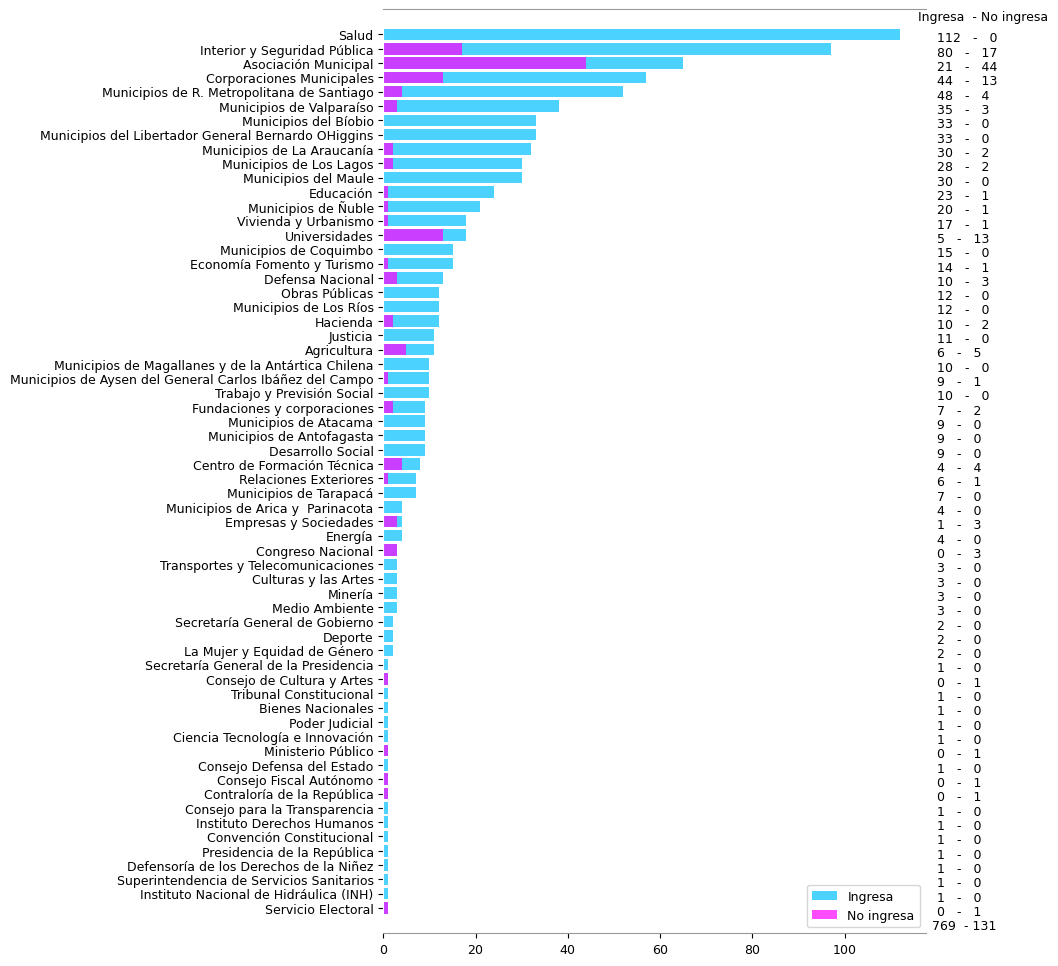

In [27]:
fig, ax = plt.subplots(figsize=(7,12))
p1 = ax.barh(dftemp['Padre_org'], dftemp['Total'], alpha=0.7, color='deepskyblue')
p2 = ax.barh(dftemp['Padre_org'], dftemp['No ingresa'], alpha=0.7, color='fuchsia')
for i, row in enumerate(dftemp['Padre_org']):
    ax.text(120, i-0.5, str(list(dftemp[dftemp['Padre_org']==row]['Ingresa'].astype(int))[0]) + '   -   '+ str(list(dftemp[dftemp['Padre_org']==row]['No ingresa'].astype(int))[0]) )

ax.text(116, 62, 'Ingresa  - No ingresa')
ax.text(119, -1.5, '769  - 131')

ax.spines['bottom'].set_color('#999')
ax.spines['top'].set_color('#999') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.margins(y = 0.022)
plt.legend(['Ingresa', 'No ingresa'], loc='lower right')
plt.show()

### Cantidad de Servicios que han informado

In [28]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query6 = '''
SELECT DISTINCT f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, f.OrganismoCodigo, s.obligadorecibir_sai, s.Ingresa 
FROM funcionarios."full" f
LEFT JOIN funcionarios.Servicios s ON f.OrganismoCodigo =s.Codigo_org 
WHERE f.anyo  > 2012
AND f.anyo * 100 + f.mesN < 202108
'''

df6 = pd.read_sql(query6, con=cnxn)

cnxn.close()

df6 = df6.drop(columns = ['OrganismoCodigo'])
df6['Año-Mes']  = df6['anyo'].astype(str) + '-' + df6['mesN']


In [29]:
df6['Fecha'] = pd.to_datetime(df6['Año-Mes'])
df6 = df6.sort_values(by=['Fecha'])

In [30]:
ticksdf = df6['Año-Mes'].drop_duplicates().reset_index(drop=True).reset_index()

In [31]:
ticks = pd.DataFrame([n for n in range(1, 102, 2)]).rename(columns={0:'col'})
ticksf = ticks.merge(ticksdf, left_on='col', right_on='index')


In [32]:
df6.groupby(by=['Año-Mes', 'Ingresa'])['Padre_org'].count()

Año-Mes  Ingresa   
2013-01  Ingresa         6
2013-02  Ingresa         7
2013-03  Ingresa         8
2013-04  Ingresa         7
2013-05  Ingresa         7
                      ... 
2021-05  No ingresa     30
2021-06  Ingresa       626
         No ingresa     28
2021-07  Ingresa       544
         No ingresa     19
Name: Padre_org, Length: 171, dtype: int64

In [33]:
import seaborn as sns
plt.figure(figsize=(10,7))
g1 = sns.catplot(kind='count', data=df6, x='Año-Mes', aspect=2)
g1.set_xticklabels(rotation=90, ha='left')
ax = g1.axes.flat
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[0].annotate('563', xy=(101.5,700), xytext=(101.5,630), bbox={'facecolor': 'cyan', 'alpha': 0.4, 'pad': 2})
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.tight_layout()
plt.savefig('img/output5.png')
plt.show()

<Figure size 1000x800 with 0 Axes>

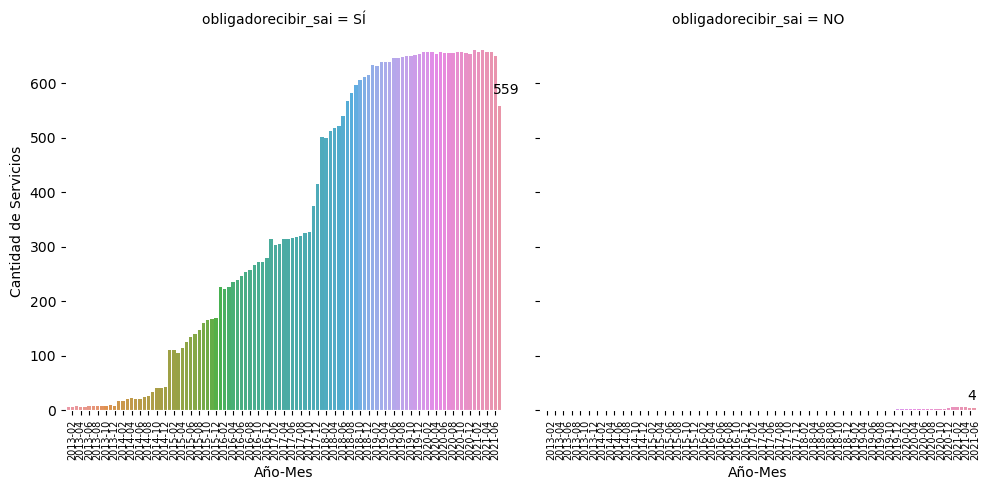

In [ ]:
import matplotlib
plt.figure(figsize=(10,8))
g1 = sns.catplot(kind='count', data=df6, x='Año-Mes', col="obligadorecibir_sai", aspect=1)
g1.set_xticklabels(rotation=90, fontsize=7)
ax = g1.axes.flat
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[1].spines['bottom'].set_color('white')
ax[0].annotate('559', xy=(100.5,580), xytext=(100.5,580))
ax[1].annotate('4', xy=(100.5,10), xytext=(100.5,20))
plt.tight_layout()
plt.savefig('img/output6.png')

plt.show()

<Figure size 1000x700 with 0 Axes>

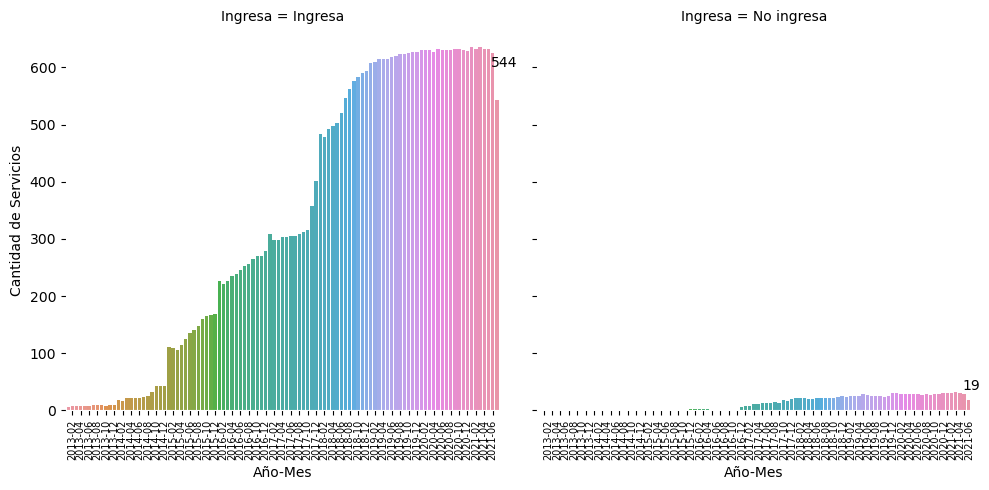

In [ ]:
plt.figure(figsize=(10,7))
g2 = sns.catplot(kind='count', data=df6, x='Año-Mes', col="Ingresa", aspect=1)
g2.set_xticklabels(rotation=90, fontsize=7)
ax = g2.axes.flat
ax[0].set_ylabel('Cantidad de Servicios')
ax[0].spines['left'].set_color('white')
ax[1].spines['left'].set_color('white')
ax[0].spines['bottom'].set_color('white')
ax[1].spines['bottom'].set_color('white')
ax[0].annotate('544', xy=(100.5,600), xytext=(100.5,600))
ax[1].annotate('19', xy=(100.5,35), xytext=(100.5,35))
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.tight_layout()
plt.savefig('img/output7.png')
plt.show()

### ¿quienes no publicaron el dato de abril?

In [ ]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
query7 = '''
SELECT DISTINCT f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, s.Organismo, s.obligadorecibir_sai, s.Ingresa, count(f.nombre ) cantidad_informada
FROM funcionarios."full" f
LEFT JOIN funcionarios.Servicios s ON f.OrganismoCodigo =s.Codigo_org 
WHERE f.anyo  > 2012
AND f.anyo * 100 + f.mesN < 202108
GROUP BY f.anyo, f.mesN, f.OrganismoCodigo, s.Padre_org, s.Organismo, s.obligadorecibir_sai, s.Ingresa
'''

df7 = pd.read_sql(query7, con=cnxn)

cnxn.close()

df7['Año-Mes']  = df7['anyo'].astype(str) + '-' + df7['mesN']
df7['fecha'] = pd.to_datetime(df7['Año-Mes'])

In [ ]:
dfmarzo = df7[df7['fecha']<='2020-06-01']
dfabril = df7[df7['fecha']=='2020-07-01']
marzo_unicos = dfmarzo[['OrganismoCodigo', 'Organismo']].drop_duplicates()
abril_unicos = dfabril[['OrganismoCodigo', 'Organismo']].drop_duplicates()
noreportaron = pd.merge(marzo_unicos, abril_unicos, how='left', left_on='OrganismoCodigo', right_on='OrganismoCodigo')
noreportaron = noreportaron[noreportaron['Organismo_y'].isna()].drop(columns=['Organismo_y'])
noreportaron['Reporta Abril'] = 'No'
noreportaron.to_excel('noreportaron.xlsx')

In [ ]:
dfabrilbox = pd.merge(df7, noreportaron, how='left', left_on='OrganismoCodigo', right_on='OrganismoCodigo').drop(columns=['Organismo_x'])
dfabrilbox['Reporta Abril'] = dfabrilbox['Reporta Abril'].fillna('Si')
dfabrilbox = dfabrilbox.groupby(by=['OrganismoCodigo', 'Organismo', 'Reporta Abril'])['cantidad_informada'].mean().reset_index()
dfabrilbox.sort_values(by=['cantidad_informada'], ascending=False)

,OrganismoCodigo,Organismo,Reporta Abril,cantidad_informada
79,AJ010,Junta Nacional de Jardines Infantiles (JUNJI),Si,19851.864865
604,MU233,Municipalidad de Puerto Montt,Si,8487.656250
669,MU308,Municipalidad de Santiago,Si,7518.987654
673,MU312,Municipalidad de Talca,Si,6724.477612
303,CM002,Corporación Municipal de Desarrollo Social de ...,Si,6376.564103
...,...,...,...,...
366,MA015,Asociación de Municipalidades de la Provincia ...,Si,1.058824
400,MA063,Asociación de Municipalidades para la Segurida...,Si,1.000000
368,MA017,Asociación de Municipalidades Desarrollo Apicu...,No,1.000000
349,EP029,Comercializadora de Trigo COTRISA,Si,1.000000


<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

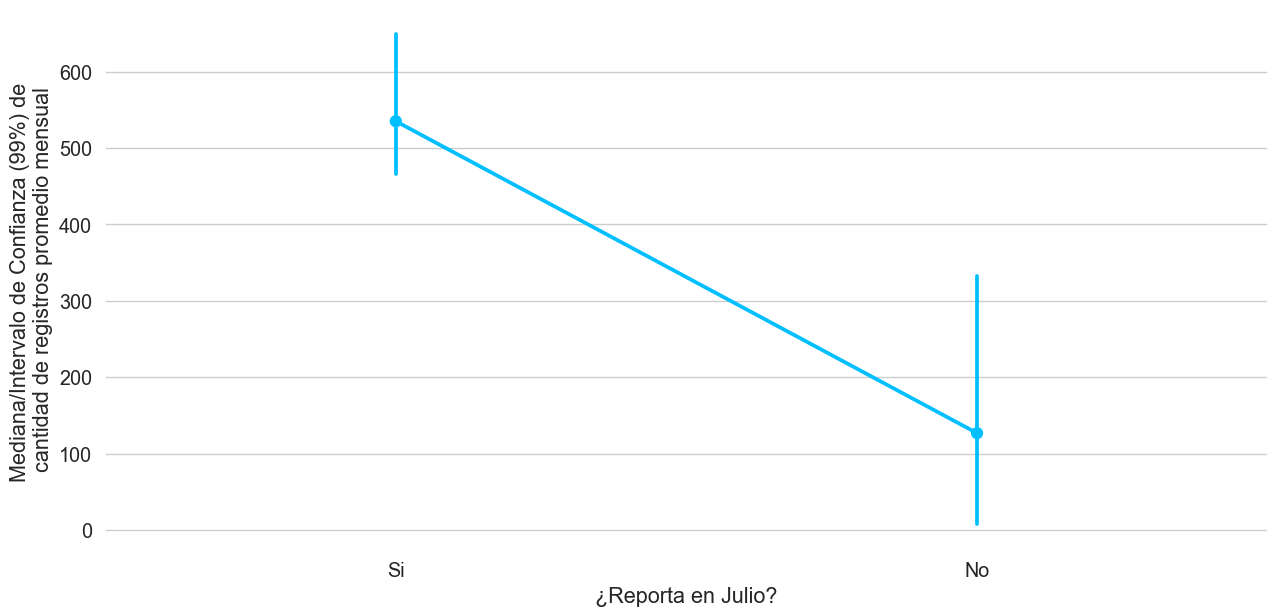

In [ ]:
plt.figure(figsize=(15,7))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
g7 = sns.pointplot(x='Reporta Abril', y='cantidad_informada', data=dfabrilbox, estimator=np.median, ci=99, label='big', color='deepskyblue')
g7.set_xlabel('¿Reporta en Julio?')
g7.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de registros promedio mensual')
g7.spines['left'].set_color('white')
g7.spines['right'].set_color('white')
g7.spines['top'].set_color('white')
g7.spines['bottom'].set_color('white')
plt.show()

### Regularidad de Publicación de los Servicios Obligados

In [ ]:
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
qPeriodos = '''
SELECT anyo , mesN , OrganismoCodigo as organismo_codigo , OrganismoNombre as organismo_nombre  
FROM funcionarios."full" f 
WHERE f.anyo  > 2012
AND f.anyo * 100 + f.mesN < 202108
'''

dfPer = pd.read_sql(qPeriodos, con=cnxn)

cnxn.close()

In [ ]:
#Variable año mes
dfPer['fecha'] = pd.to_datetime(dfPer['anyo'].astype(str)+'/'+dfPer['mesN'].astype(str))

In [ ]:
#Calculo de periodos que debería haber publicado
dfMesIni = dfPer.groupby(by=['organismo_codigo'])['fecha'].min().reset_index()
dfMesIni['max'] = pd.to_datetime('2021-07-01')
dfMesIni['diff'] = (dfMesIni['max'] - dfMesIni['fecha'])
dfMesIni['diff'] = round(dfMesIni['diff']/np.timedelta64(1,'M') + 1)

In [ ]:
dfMesIni

,organismo_codigo,fecha,max,diff
0,AA001,2018-10-01,2021-07-01,34.0
1,AB002,2018-04-01,2021-07-01,40.0
2,AB004,2017-11-01,2021-07-01,45.0
3,AB075,2019-08-01,2021-07-01,24.0
4,AB076,2018-08-01,2021-07-01,36.0
...,...,...,...,...
701,MU344,2015-05-01,2021-07-01,75.0
702,MU345,2016-01-01,2021-07-01,67.0
703,PP030,2016-01-01,2021-07-01,67.0
704,UN017,2016-07-01,2021-07-01,61.0


In [ ]:
#Calculo de peridos que ha publicado
dfPubl = dfPer.groupby(by=['organismo_codigo'])['fecha'].nunique().reset_index().rename(columns={'fecha':'Qpublica'})

In [ ]:
# Merges y filtros para obtener dataset final
dfRegula = dfMesIni.merge(dfPubl, how = 'left', left_on = 'organismo_codigo', right_on = 'organismo_codigo')
dfRegula['indicador'] = round(dfRegula['Qpublica']/dfRegula['diff'] * 100, 1)
df4TotalF = df5[df5['obligadorecibir_sai'] == 'SÍ']
dfRegula = dfRegula.merge(df4TotalF, how = 'inner', left_on = 'organismo_codigo', right_on = 'Codigo_org')
dfRegula = dfRegula[['organismo_codigo', 'fecha', 'diff', 'Qpublica','indicador', 'Organismo']]

dfRegula = dfRegula.sort_values(by = 'indicador', ascending = True)

In [ ]:
# Calculo de variables a usar en parrafo
novel = int(min(dfRegula['diff']))
qnovel = int(len(dfRegula[dfRegula['diff'] == novel]))
noveles = dfRegula[dfRegula['diff'] == novel]
noveles = noveles[['Organismo']].sort_values(by = 'Organismo')

old = int(max(dfRegula['diff']))
qold = int(len(dfRegula[dfRegula['diff'] == old]))
olds = dfRegula[dfRegula['diff'] == old]
olds = olds[['Organismo']].sort_values(by = 'Organismo')

maximo = int(len(dfRegula[dfRegula['indicador'] == 100]))
hanpubli = len(dfRegula)
porcentaje = round(maximo / hanpubli * 100, 2)

peores = dfRegula[['Organismo', 'indicador']].head(25)

In [ ]:
display(noveles)

,Organismo
247,SERVIU Región de Antofagasta


In [ ]:
olds

,Organismo
308,Corporación Municipal de Educación y Servicios...
480,Municipalidad de Graneros
531,Municipalidad de Macul
581,Municipalidad de Peumo
590,Municipalidad de Porvenir
627,Municipalidad de Rio Bueno


In [ ]:
dfRegula[dfRegula['indicador'] == 100]

,organismo_codigo,fecha,diff,Qpublica,indicador,Organismo
654,MU297,2016-12-01,56.0,56,100.0,Municipalidad de San Pedro
475,MU095,2016-04-01,64.0,64,100.0,Municipalidad de Futaleufú
664,MU311,2015-01-01,79.0,79,100.0,Municipalidad de Talagante
476,MU096,2018-03-01,41.0,41,100.0,Municipalidad de Futrono
501,MU124,2018-01-01,43.0,43,100.0,Municipalidad de La Pintana
...,...,...,...,...,...,...
312,CM016,2016-01-01,67.0,67,100.0,Corporación Municipal de Desarrollo Social de ...
311,CM015,2016-07-01,61.0,61,100.0,Corporación Municipal de Valparaíso
309,CM013,2016-05-01,63.0,63,100.0,Corporación Municipal de Quellón
266,AR005,2018-03-01,41.0,41,100.0,Oficinas de Estudios y Políticas Agrarias (ODEPA)


In [ ]:
peores.to_excel('peores.xlsx')
display(peores)

,Organismo,indicador
593,Municipalidad de Puchuncaví,1.2
464,Municipalidad de El Carmen,1.4
304,Corporación Municipal de Maipú (CODEDUC),1.6
686,Municipalidad de Vicuña,1.8
386,Asociación de Municipalidades del Valle del Maipo,2.0
368,Asociación Municipalidades Provincia de Llanqu...,2.2
28,Carabineros de Chile,2.3
355,Asociación de Municipalidades Territorio de Ri...,2.5
381,Asociación de Municipalidades para la Preserva...,3.1
361,Asociación de Municipalidades Desarrollo Apicu...,3.8


# Falta de estandarización de datos

In [ ]:
import pandas as pd
#Generamos la conexión
cnxn = vertica_python.connect(**conn_info)

# Hacemos la query  e importamos el resultado en un df
sqlestandariza = '''
SELECT TipoEstamento, TipoCargo, GradoEus, TipoCalificacionp, nombre, anyo, Mes, MesN, OrganismoNombre 
FROM funcionarios."full" f 
WHERE f.anyo  > 2012
AND f.anyo * 100 + f.mesN < 202108
'''
standar= pd.read_sql(sqlestandariza , con = cnxn)

cnxn.close()

In [ ]:
standar['mesAño'] = standar['anyo'].astype(str) + '-' + standar['MesN']
standar['fecha'] = pd.to_datetime(standar['mesAño'])

## Tipo de estamento

In [ ]:
dfestamento = standar[['TipoEstamento']].drop_duplicates()
cantTE = len(dfestamento)
estClaros = dfestamento.sort_values('TipoEstamento').head()
estRaros = dfestamento.sort_values('TipoEstamento').tail()
display(cantTE)
display(estClaros)
display(estRaros)

35

,TipoEstamento
30381247,(1) Presidente del Consejo Directivo
529,Administrativo
1451,Administrativos de Salud
24924,Alcalde
4730487,Alcaldesa


,TipoEstamento
3,Técnico
1075,Técnicopedagógico
750,Técnicos de Salud
0,Técnicos de nivel superior (Ley 19.378)
18634982,None


In [ ]:
tepoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoEstamento'].nunique().reset_index()
tepoint2 = standar.groupby(by=['fecha'])['TipoEstamento'].nunique().reset_index()

In [ ]:
tepoint2.tail(2)

,fecha,TipoEstamento
101,2021-06-01,30
102,2021-07-01,30


In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 

fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoEstamento', data=tepoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoEstamento', data=tepoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de estamentos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de estamentos distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.show()

NameError: name 'ticksf' is not defined

In [ ]:
tebox = standar.groupby(by=['OrganismoNombre'])['TipoEstamento'].nunique().reset_index()
tebox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
tebox['qf'] =tebox2['nombre']
tebox['ind']=round(tebox['TipoEstamento']/tebox['qf'], 3)
tebox=tebox[tebox['qf']>50]

In [ ]:
tebox.sort_values(by=['ind'], ascending=False).median()

TipoEstamento       7.000
qf               1271.000
ind                 0.007
dtype: float64

In [ ]:
teboxS = standar.groupby(by=['TipoEstamento'])['OrganismoNombre'].nunique().reset_index()
display(len(teboxS[teboxS['OrganismoNombre']>=10])/len(teboxS)*100)

81.81818181818183

### Tipo Cargo

In [ ]:
dftcar = standar[['TipoCargo']].drop_duplicates()
cantTC = len(dftcar)
carClaros = dftcar.sort_values('TipoCargo').head(20)
display(cantTC)
display(carClaros)

328936

,TipoCargo
15225924,(01)Chero
1301404,(1)+I8:L9
12655950,(131)(26)(51)(37)(43)(46)(08)(09)
442845,(A999 ) Departamento De Educacion
442847,(C095 ) Liceo De La Frontera
443015,(C950 ) Liceo La Frontera Educ. Media
443082,(F1051) Escuela Rihue
443150,(F1052) Escuela Coigue
443228,(G1049) Escuela De Vaqueria
3596910,(S) Director Seguridad Publica


In [ ]:
tcpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoCargo'].nunique().reset_index()
tcpoint2 = standar.groupby(by=['fecha'])['TipoCargo'].nunique().reset_index()


In [ ]:
tcpoint.tail()

,fecha,OrganismoNombre,TipoCargo
25871,2020-04-01,Superintendencia De Servicios Sanitarios (Siss),87
25872,2020-04-01,Superintendencia Del Medio Ambiente (Sma),128
25873,2020-04-01,Tesorería General De La República (Tgr),374
25874,2020-04-01,Unidad De Análisis Financiero,39
25875,2020-04-01,Universidad De Aysén,76


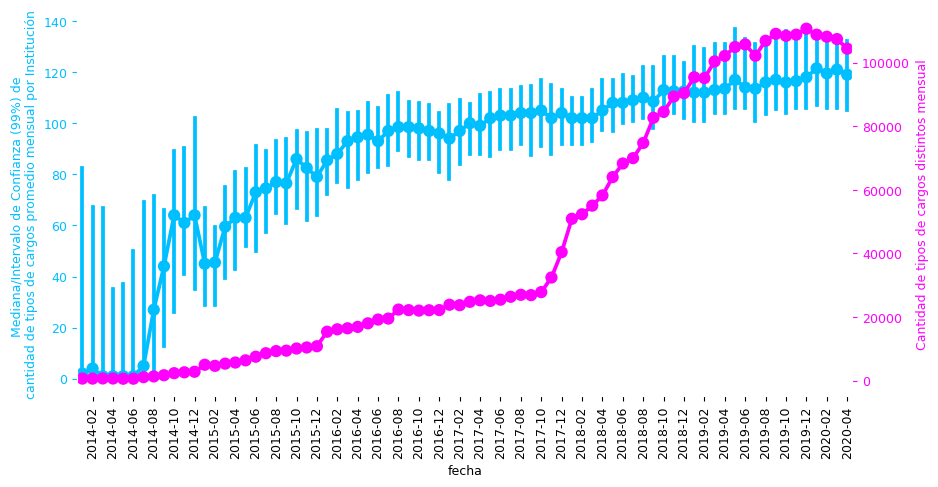

In [ ]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoCargo', data=tcpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoCargo', data=tcpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de cargos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de cargos distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.show()

In [ ]:
tcbox = standar.groupby(by=['OrganismoNombre'])['TipoCargo'].nunique().reset_index()
tcbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
tcbox['qf'] =tcbox2['nombre']
tcbox['ind']=round(tcbox['TipoCargo']/tcbox['qf'], 3)
tcbox=tcbox[tcbox['qf']>50]

In [ ]:
tcbox.sort_values(by=['ind'], ascending=False).median()

TipoCargo     276.000
qf           1271.000
ind             0.322
dtype: float64

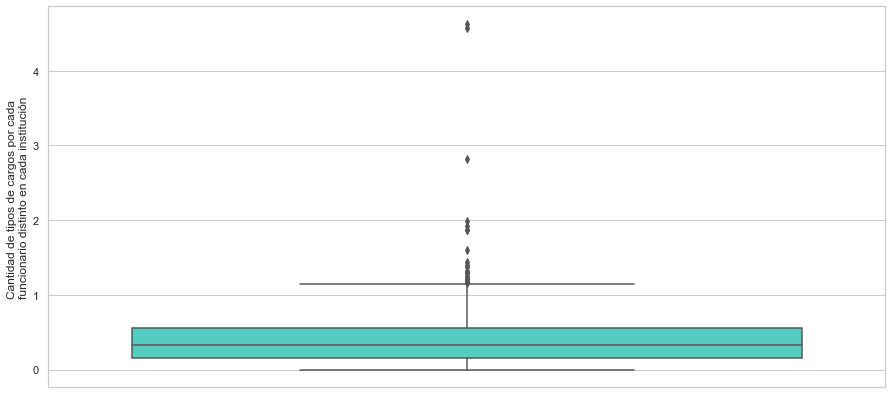

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=tcbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de cargos por cada \nfuncionario distinto en cada institución')
plt.show()

In [ ]:
tcboxS = standar.groupby(by=['TipoCargo'])['OrganismoNombre'].nunique().reset_index()
display(tcboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(tcboxS[tcboxS['OrganismoNombre']>=10])/len(tcboxS)*100)

,TipoCargo,OrganismoNombre
7742,Administrativo,475
68358,Auxiliar,414
56978,Asistente Social,413
286013,Secretaria,399
89251,Chofer,399


0.4475048261814644

## Grados

In [ ]:
dfgrados = standar[['GradoEus']].drop_duplicates()
cantG = len(dfgrados)
gClaros = dfgrados.sort_values('GradoEus').head()
display(cantG)
display(gClaros)

18085

,TipoEstamento
583380,(1) Presidente del Consejo Directivo
512,Administrativo
177540,Administrativos de Salud
232766,Alcalde
238891,Autoridad de Gobierno


,GradoEus
6474903,(01)
15225924,(01) Asimilado a Grado
15065287,(11 Hrs.)
9676338,(12 Jornada)
20291855,(13)


In [ ]:
gpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['GradoEus'].nunique().reset_index()
gpoint2 = standar.groupby(by=['fecha'])['GradoEus'].nunique().reset_index()

In [ ]:
gpoint2.tail()

,fecha,GradoEus
71,2019-12-01,4634
72,2020-01-01,4810
73,2020-02-01,4390
74,2020-03-01,4314
75,2020-04-01,4186


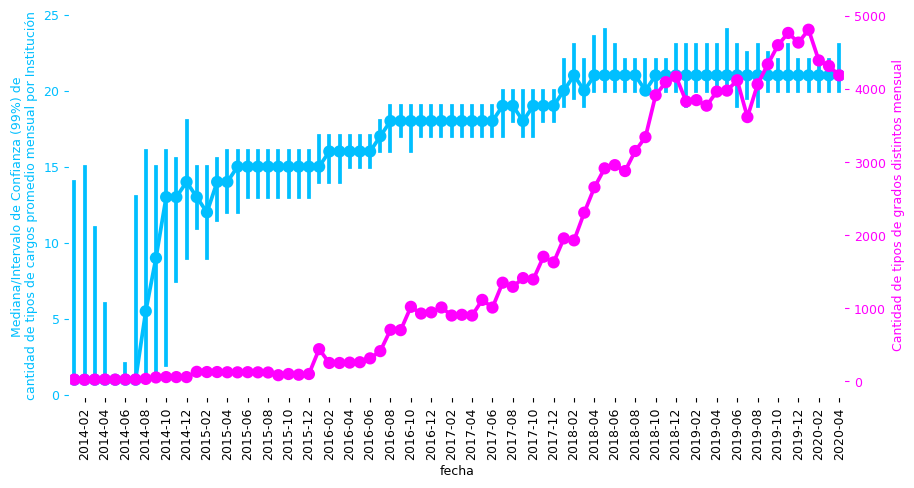

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='GradoEus', data=gpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='GradoEus', data=gpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de cargos promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de grados distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.show()

In [ ]:
gbox = standar.groupby(by=['OrganismoNombre'])['GradoEus'].nunique().reset_index()
gbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
gbox['qf'] =gbox2['nombre']
gbox['ind']=round(gbox['GradoEus']/gbox['qf'], 4)
gbox=gbox[gbox['qf']>50]

In [ ]:
gbox.sort_values(by=['ind'], ascending=False).median()

GradoEus      29.0000
qf          1271.0000
ind            0.0345
dtype: float64

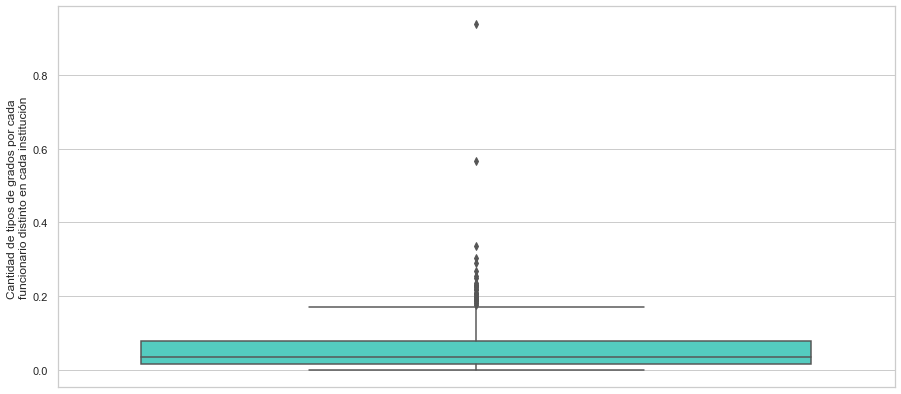

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=gbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de grados por cada \nfuncionario distinto en cada institución')
plt.show()

In [ ]:
GboxS = standar.groupby(by=['GradoEus'])['OrganismoNombre'].nunique().reset_index()
display(GboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(GboxS[GboxS['OrganismoNombre']>=10])/len(tcboxS)*100)

,GradoEus,OrganismoNombre
404,12,574
2623,8,573
602,14,572
185,10,570
518,13,569


0.10883609223706811

### Tipo Calificación

In [ ]:
calfgrados = standar[['TipoCalificacionp']].drop_duplicates()
cantCal = len(calfgrados)
CalClaros = calfgrados.sort_values('TipoCalificacionp').head()
display(cantCal)
display(CalClaros)

146143

,TipoCalificacionp
585734,(01)
8063716,(02)
8531339,(07)(33)(51)(12)
6785659,(07)+A45:I46(33)(37)(51)
15660557,(146)(64)(03)(87)(107)(131)


In [ ]:
calpoint = standar.groupby(by=['fecha', 'OrganismoNombre'])['TipoCalificacionp'].nunique().reset_index()
calpoint2 = standar.groupby(by=['fecha'])['TipoCalificacionp'].nunique().reset_index()

In [ ]:
calpoint2.tail()

,fecha,TipoCalificacionp
71,2019-12-01,49137
72,2020-01-01,45769
73,2020-02-01,45667
74,2020-03-01,44795
75,2020-04-01,43420


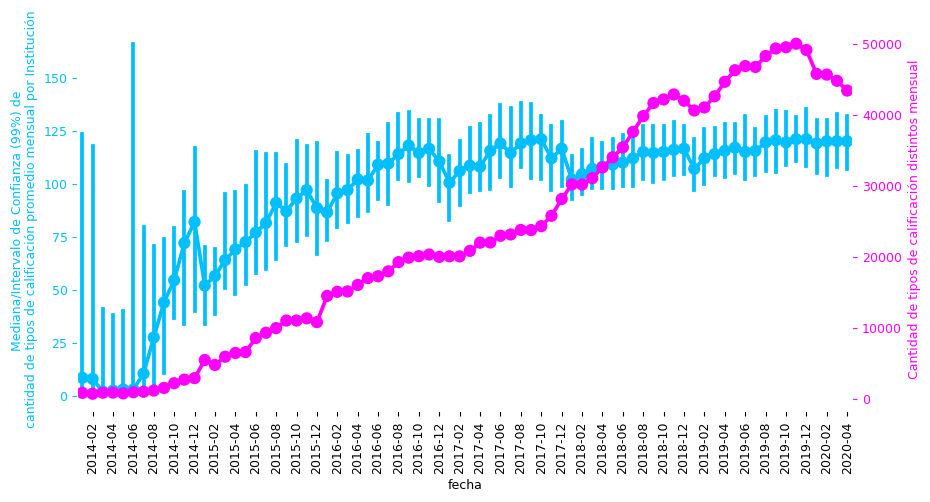

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.pointplot(x='fecha', y='TipoCalificacionp', data=calpoint, estimator=np.median, ci=99, label='big', color='deepskyblue', ax=ax1)
ax2 = ax1.twinx()
sns.pointplot(x='fecha', y='TipoCalificacionp', data=calpoint2, estimator=np.median, ci=99, label='big', color='magenta', ax=ax2)
stepsize = 1
start, end = ax1.get_xlim()
ax1.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_ylabel('Mediana/Intervalo de Confianza (99%) de \ncantidad de tipos de calificación promedio mensual por Institución')
ax2.set_ylabel('Cantidad de tipos de calificación distintos mensual')
ax1.yaxis.label.set_color('deepskyblue')
ax2.yaxis.label.set_color('magenta')
ax1.tick_params(axis='y', colors='deepskyblue')
ax2.tick_params(axis='y', colors='magenta')
ax2.xaxis.set_ticks(np.arange(start, end, stepsize)) 
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.grid(color='white', alpha=0)
ax2.grid(color='white', alpha=0)
ax1.spines['left'].set_color('white')
ax1.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['bottom'].set_color('white')
ax2.spines['left'].set_color('white')
ax2.spines['right'].set_color('white')
ax2.spines['top'].set_color('white')
ax2.spines['bottom'].set_color('white')
plt.xticks(ticksf['col'], ticksf['Año-Mes'],ha='left')
plt.show()

In [ ]:
calbox = standar.groupby(by=['OrganismoNombre'])['TipoCalificacionp'].nunique().reset_index()
calbox2 = standar.groupby(by=['OrganismoNombre'])['nombre'].nunique().reset_index()
calbox['qf'] =calbox2['nombre']
calbox['ind']=round(calbox['TipoCalificacionp']/calbox['qf'], 4)
calbox=calbox[calbox['qf']>50]

In [ ]:
calbox.sort_values(by=['ind'], ascending=False).median()

TipoCalificacionp     291.0000
qf                   1271.0000
ind                     0.3052
dtype: float64

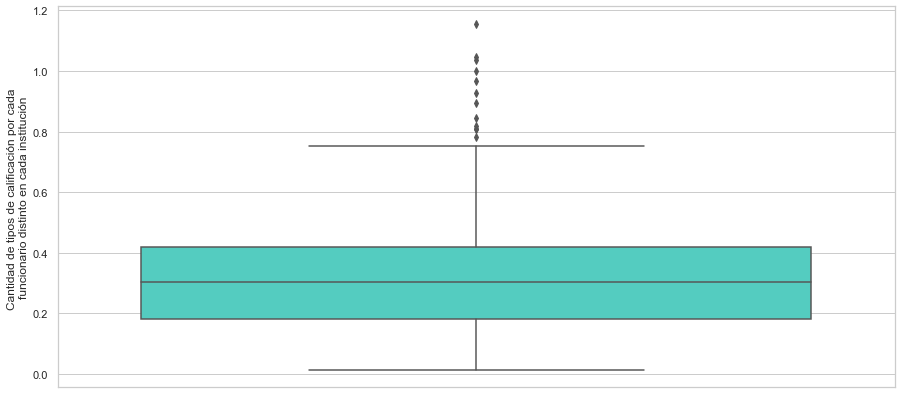

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,7))
sns.boxplot(y='ind', data=calbox, color='turquoise', ax=ax1)
ax1.set_ylabel('Cantidad de tipos de calificación por cada \nfuncionario distinto en cada institución')
plt.show()

In [ ]:
calboxS = standar.groupby(by=['TipoCalificacionp'])['OrganismoNombre'].nunique().reset_index()
display(calboxS.sort_values(by=['OrganismoNombre'], ascending=False).head(5))
display(len(calboxS[calboxS['OrganismoNombre']>=10])/len(tcboxS)*100)
display((len(calboxS[calboxS['OrganismoNombre']>=10])))

,TipoCalificacionp,OrganismoNombre
2125,Abogado,608
54358,Ingeniero Comercial,604
12306,Asistente Social,603
19784,Contador Auditor,590
81448,Periodista,546


0.8761609436514812

2882